**CODETECH INTERNSHIPS**

**Task 2--  SENTIMENT ANALYSIS WITH NLP**

PERFORM SENTIMENT ANALYSIS ON A DATASET OF CUSTOMER REVIEWS USING TF-IDF VECTORIZATION AND LOGISTIC REGRESSION.

**DELIVERABLE**: A JUPYTER NOTEBOOK SHOWCASING PREPROCESSING, MODELING,AND SENTIMENT EVALUATION

In [1]:
## Optional: Install specific versions (Colab usually has these preinstalled)
# !pip -q install --upgrade scikit-learn pandas matplotlib joblib

import io, re, warnings, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('Imports ready!')


Imports ready!


## 1) Upload your CSV (manual upload in Colab)
Run the cell and pick your `.csv` file from your computer.

In [2]:
from google.colab import files
uploaded = files.upload()  # Pick your CSV file
fname = next(iter(uploaded))
print('Loaded file:', fname)

# Try UTF-8, fallback to latin-1
try:
    df = pd.read_csv(io.BytesIO(uploaded[fname]))
except UnicodeDecodeError:
    df = pd.read_csv(io.BytesIO(uploaded[fname]), encoding='latin-1')

print('Rows:', len(df), ' Columns:', list(df.columns))
display(df.head())


Saving review.csv to review.csv
Loaded file: review.csv
Rows: 280  Columns: ['Review Title', 'Customer name', 'Rating', 'Date', 'Category', 'Comments', 'Useful']


,Review Title,Customer name,Rating,Date,Category,Comments,Useful
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,on 1 October 2018,Display,Another Midrange killer Smartphone by Xiaomi\n...,
1,vry small size mobile,Raza ji,3.0 out of 5 stars,on 15 September 2018,Others,All ok but vry small size mobile,7 people found this helpful
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,on 18 September 2018,Others,Quite good,7 people found this helpful
3,Value for Money,Amazon Customer,5.0 out of 5 stars,on 28 September 2018,Display,Redmi has always have been the the king of bud...,2 people found this helpful
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,on 18 September 2018,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful


## 2) Choose your text and label columns
If you **already know** your column names, set them below. Otherwise, leave as `None` and the notebook will try to **auto-detect** sensible defaults (you'll see what it picked and can change them).

In [3]:
# 🔧 If you know the exact column names, set them here (example below). Otherwise keep None.
TEXT_COL = None   # e.g., 'review', 'text', 'message', 'content'
LABEL_COL = None  # e.g., 'label', 'sentiment', 'target', 'rating'

def _auto_pick_columns(df):
    # Candidate text columns: object (string) dtype
    obj_cols = [c for c in df.columns if df[c].dtype == 'object']
    text_col_guess = None
    if obj_cols:
        # Choose the object column with the longest average length
        avg_lens = {}
        for c in obj_cols:
            try:
                avg_lens[c] = df[c].astype(str).str.len().mean()
            except Exception:
                avg_lens[c] = 0
        text_col_guess = max(avg_lens, key=avg_lens.get)

    # Label guess based on common names first
    common_label_names = [
        'label','sentiment','target','polarity','class','output','sentiment_label',
        'rating','stars','review_rating','score'
    ]
    for name in common_label_names:
        if name in df.columns:
            label_col_guess = name
            break
    else:
        # Fall back: look for low-cardinality columns (<= 5 unique values)
        label_col_guess = None
        for c in df.columns:
            nunique = df[c].nunique(dropna=True)
            if nunique <= 5 and c != text_col_guess:
                label_col_guess = c
                break

    return text_col_guess, label_col_guess

auto_text, auto_label = _auto_pick_columns(df)
TEXT_COL = TEXT_COL or auto_text
LABEL_COL = LABEL_COL or auto_label

print('Auto-detected:')
print('  TEXT_COL =', TEXT_COL)
print('  LABEL_COL =', LABEL_COL)
if TEXT_COL is None or LABEL_COL is None:
    raise ValueError('❗Could not auto-detect columns. Please set TEXT_COL and LABEL_COL manually above.')

# Preview selected columns
display(df[[TEXT_COL, LABEL_COL]].head())
print('Label distribution:')
print(df[LABEL_COL].value_counts(dropna=False))


Auto-detected:
  TEXT_COL = Comments
  LABEL_COL = Rating


,Comments,Rating
0,Another Midrange killer Smartphone by Xiaomi\n...,4.0 out of 5 stars
1,All ok but vry small size mobile,3.0 out of 5 stars
2,Quite good,3.0 out of 5 stars
3,Redmi has always have been the the king of bud...,5.0 out of 5 stars
4,worst product from MI. I am a hardcore fan of ...,2.0 out of 5 stars


Label distribution:
Rating
5.0 out of 5 stars    151
4.0 out of 5 stars     50
1.0 out of 5 stars     43
3.0 out of 5 stars     27
2.0 out of 5 stars      9
Name: count, dtype: int64


## 3) Basic text cleaning
Vectorizers can handle punctuation, but simple cleaning often helps. You can customize the `clean_text` function.

In [4]:
def clean_text(s: str) -> str:
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)  # URLs
    s = re.sub(r'<.*?>', ' ', s)                    # HTML
    s = re.sub(r"[^\w\s]", ' ', s)               # punctuation
    s = re.sub(r"\d+", ' ', s)                    # digits
    s = re.sub(r"\s+", ' ', s).strip()
    return s

df['_clean_text'] = df[TEXT_COL].apply(clean_text)
display(df[[TEXT_COL, '_clean_text', LABEL_COL]].head())


,Comments,_clean_text,Rating
0,Another Midrange killer Smartphone by Xiaomi\n...,another midrange killer smartphone by xiaomi m...,4.0 out of 5 stars
1,All ok but vry small size mobile,all ok but vry small size mobile,3.0 out of 5 stars
2,Quite good,quite good,3.0 out of 5 stars
3,Redmi has always have been the the king of bud...,redmi has always have been the the king of bud...,5.0 out of 5 stars
4,worst product from MI. I am a hardcore fan of ...,worst product from mi i am a hardcore fan of m...,2.0 out of 5 stars


## 4) Train/validation split

In [5]:
X = df['_clean_text']
y = df[LABEL_COL].astype(str)  # ensure string labels work fine

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if y.nunique()>1 else None
)
len(X_train), len(X_test), y_train.value_counts().to_dict()


(224,
 56,
 {'5.0 out of 5 stars': 121,
  '4.0 out of 5 stars': 40,
  '1.0 out of 5 stars': 34,
  '3.0 out of 5 stars': 22,
  '2.0 out of 5 stars': 7})

## 5) Build the TF‑IDF + Logistic Regression pipeline
Tweak `ngram_range`, `min_df`, or `max_features` for performance/quality tradeoffs.

In [6]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=100_000,
    stop_words=None,   # set to 'english' if your data is English
)

logreg = LogisticRegression(
    solver='liblinear',
    C=2.0,
    max_iter=300,
    class_weight='balanced'  # helps with imbalance
)

pipe = Pipeline([
    ('tfidf', tfidf),
    ('logreg', logreg)
])

pipe.fit(X_train, y_train)
print('Model trained!')


Model trained!


## 6) Evaluation: accuracy, F1, classification report, confusion matrix, ROC‑AUC (binary)

Accuracy: 0.7321
F1-macro: 0.6090

Classification Report:
                     precision    recall  f1-score   support

1.0 out of 5 stars       0.78      0.78      0.78         9
2.0 out of 5 stars       1.00      1.00      1.00         2
3.0 out of 5 stars       0.00      0.00      0.00         5
4.0 out of 5 stars       1.00      0.30      0.46        10
5.0 out of 5 stars       0.69      0.97      0.81        30

          accuracy                           0.73        56
         macro avg       0.69      0.61      0.61        56
      weighted avg       0.71      0.73      0.67        56



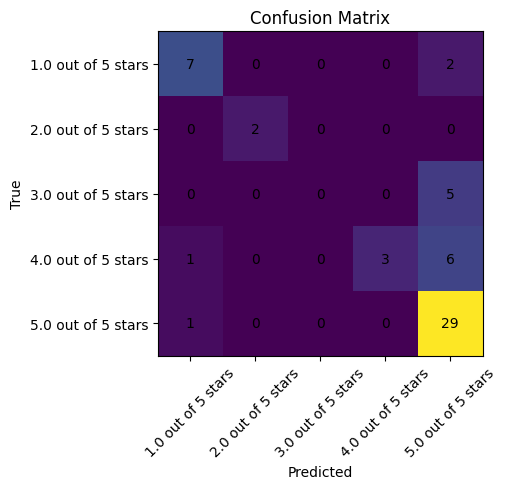

In [7]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.4f}\nF1-macro: {f1_macro:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
fig = plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks(range(len(cm)), sorted(y.unique()), rotation=45)
plt.yticks(range(len(cm)), sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.tight_layout()
plt.show()

# ROC-AUC (binary only)
if y.nunique() == 2:
    # Get positive class probs in a label-stable way
    classes = list(pipe.classes_)
    pos_idx = 1 if len(classes) > 1 else 0
    y_proba = pipe.predict_proba(X_test)[:, pos_idx]
    try:
        auc = roc_auc_score((y_test == classes[pos_idx]).astype(int), y_proba)
        print(f'ROC-AUC: {auc:.4f}')
        RocCurveDisplay.from_predictions((y_test == classes[pos_idx]).astype(int), y_proba)
        plt.title('ROC Curve (binary)')
        plt.show()
    except Exception as e:
        print('ROC-AUC could not be computed:', e)


## 7) Cross‑validation
We run 5‑fold stratified cross‑validation on the **training** split to estimate generalization.

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro')
print('5‑Fold CV F1-macro:', scores)
print('Mean:', scores.mean().round(4), '±', scores.std().round(4))


5‑Fold CV F1-macro: [0.66552381 0.36714286 0.43699758 0.52323232 0.64590188]
Mean: 0.5278 ± 0.1158


## 8) Most informative words/phrases
Shows top features per class (based on Logistic Regression coefficients).

In [9]:
def top_terms_per_class(pipe, top_k=25):
    vec = pipe.named_steps['tfidf']
    clf = pipe.named_steps['logreg']
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_
    classes = clf.classes_
    for idx, cls in enumerate(classes):
        print(f'\nTop + terms for class: {cls}')
        top_pos_idx = np.argsort(coefs[idx])[::-1][:top_k]
        print(', '.join(feature_names[top_pos_idx]))
        print(f'\nTop − terms for class: {cls}')
        top_neg_idx = np.argsort(coefs[idx])[:top_k]
        print(', '.join(feature_names[top_neg_idx]))

top_terms_per_class(pipe, top_k=20)



Top + terms for class: 1.0 out of 5 stars
not, issue, worst, not good, replacement, waste, please, worst phone, no, waste of, not buy, bad, do not, do, are, of, both, of money, working, buy

Top − terms for class: 1.0 out of 5 stars
good, nice, best, awesome, like, not ok, super, great, value, thanks, product, all, one, good phone, value for, love, note, mobile, average, really

Top + terms for class: 2.0 out of 5 stars
quality and, you, heating, problem, camera quality, buy, disappointing, from mi, fan, you think, new mobile, dual if, mobile you, you buy, think new, buy realme, if you, bad, this, of mi

Top − terms for class: 2.0 out of 5 stars
good, nice, best, is, awesome, in, battery, ok, money, super, display, not, price, is good, all, great, its, it, amazon, good phone

Top + terms for class: 3.0 out of 5 stars
average, poor, super, not, well, sound, all is, but not, is not, but, all, the, size mobile, vry small, ok but, but vry, vry, all ok, rear camera, performance

Top − term

## 9) Try a few custom predictions

In [10]:
examples = [
    'Absolutely loved it! Great quality and fast shipping.',
    'Terrible experience. The product broke after one day.',
]
examples_clean = [clean_text(x) for x in examples]
preds = pipe.predict(examples_clean)
for e, p in zip(examples, preds):
    print(f'{e} -> {p}')


Absolutely loved it! Great quality and fast shipping. -> 5.0 out of 5 stars
Terrible experience. The product broke after one day. -> 5.0 out of 5 stars


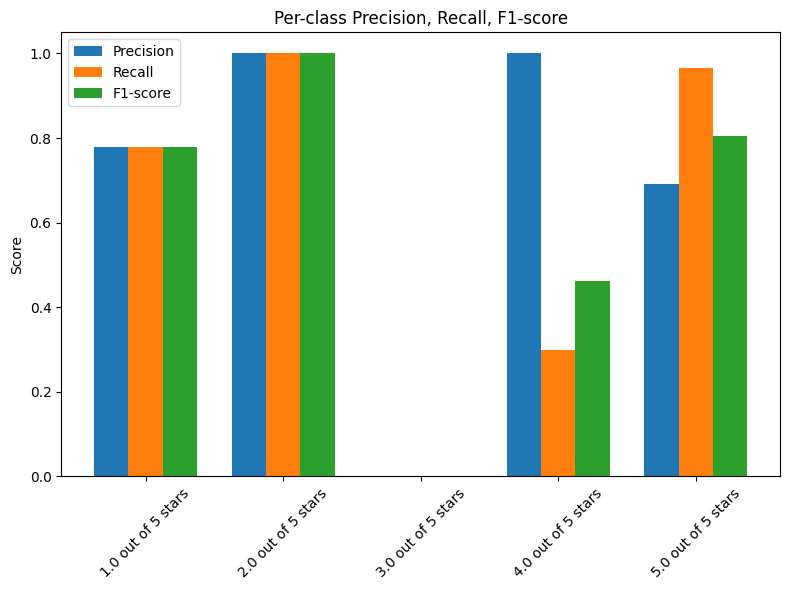

In [12]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, f1 for each class
precisions, recalls, f1s, supports = precision_recall_fscore_support(y_test, y_pred, labels=sorted(y.unique()))

classes = sorted(y.unique())
x = np.arange(len(classes))  # class indices
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width, precisions, width, label='Precision')
ax.bar(x, recalls, width, label='Recall')
ax.bar(x + width, f1s, width, label='F1-score')

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Per-class Precision, Recall, F1-score")
ax.legend()
plt.tight_layout()
plt.show()


## 10) Save & Download the trained pipeline
This saves the **entire pipeline** (clean text → TF‑IDF → Logistic Regression). You can load it later and call `.predict()` on new texts.

In [11]:
model_path = 'sentiment_tfidf_logreg.pkl'
joblib.dump(pipe, model_path)
print('Saved to', model_path)

try:
    from google.colab import files
    files.download(model_path)
except Exception:
    print('If running outside Colab, manually download the file from the working directory.')


Saved to sentiment_tfidf_logreg.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>